In [2]:
#importing necessary models
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

I had used already trained a model named pfarmer.h5 using a P100 on a kaggle notebook, now i am loading it and retraining it to improivise the accuracy of the model.

In [3]:
#loading pretrained model
import tensorflow as tf
model = tf.keras.models.load_model('C:/Personal/12/ai/PF/pfarmer.h5')


(352, 330, 4)


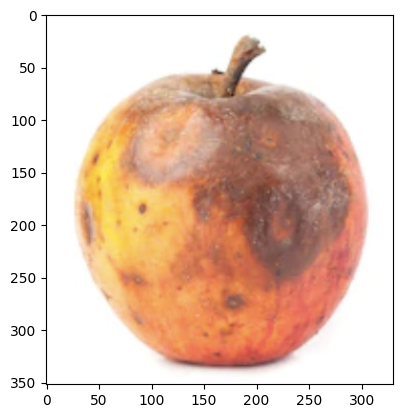

In [4]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
#Rotten example:
show_image("C:/Personal/12/ai/PF/main_dataset/dataset/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.15.34 PM.png")


(398, 374, 3)


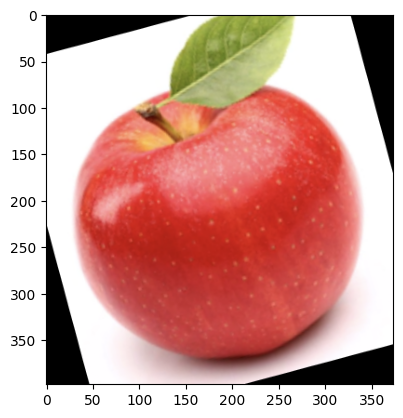

In [5]:

#Fresh Example:
show_image("C:/Personal/12/ai/PF/main_dataset/dataset/dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.01.01 PM.png")

In [6]:
#Freezing the model so that it doesnt use pre-trained weights
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False);

base_model.trainable = False  

In [7]:
#Define layers
inputs =  keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1,activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
#compile the model

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

In [9]:
datagen_train = ImageDataGenerator(
    samplewise_center=True,  
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,  
    vertical_flip=True,
)  

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [10]:
train_it = datagen_train.flow_from_directory(
    'C://Personal/12/ai/PF/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

valid_it = datagen_valid.flow_from_directory(
    'C://Personal/12/ai/PF/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

Found 10901 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.


In [13]:
#Training phase ( took me 164 mins on my laptop :[ )
model.fit(train_it,
          validation_data = valid_it,
          steps_per_epoch = train_it.samples/train_it.batch_size, 
          validation_steps = valid_it.samples/valid_it.batch_size, 
          epochs = 5)

Epoch 1/5
340/340 [==============================] - 2030s 6s/step - loss: 0.2972 - binary_accuracy: 0.8911 - val_loss: 0.1382 - val_binary_accuracy: 0.9566
Epoch 2/5
340/340 [==============================] - 1981s 6s/step - loss: 0.0939 - binary_accuracy: 0.9647 - val_loss: 0.0884 - val_binary_accuracy: 0.9718
Epoch 3/5
340/340 [==============================] - 2127s 6s/step - loss: 0.0772 - binary_accuracy: 0.9733 - val_loss: 0.0710 - val_binary_accuracy: 0.9807
Epoch 4/5
340/340 [==============================] - 1864s 5s/step - loss: 0.0699 - binary_accuracy: 0.9751 - val_loss: 0.0652 - val_binary_accuracy: 0.9792
Epoch 5/5
340/340 [==============================] - 1860s 5s/step - loss: 0.0571 - binary_accuracy: 0.9794 - val_loss: 0.0644 - val_binary_accuracy: 0.9815


In [59]:
model.save('pfarmer2.h5')  #improvised version with a 97% accuracy

c:\Users\eashw\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
#compile the model

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

In [61]:
def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [62]:
def kaboom(image_path):
    preds = make_predictions(image_path)
    if preds <= 0.5:
        print("It's Fresh! eat ahead.")
    else:
        print("It's Rotten, I wont recommend!")

(270, 286, 4)
1/1 [==============================] - 0s 316ms/step
It's Rotten, I wont recommend!


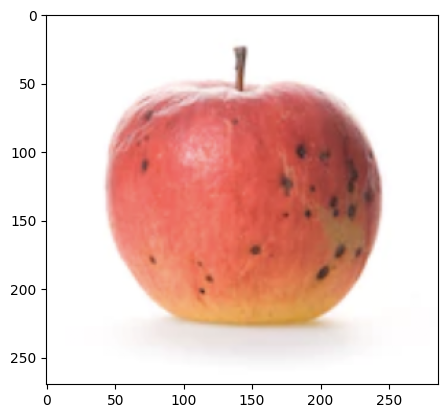

In [63]:
#test 
kaboom('C:/Personal/12/ai/PF/test/stale/Screen Shot 2018-06-07 at 2.34.49 PM.png')

In [91]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import os
import requests
from io import BytesIO
from keras.preprocessing import image as image_utils
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

# Load your model (please replace with your actual model path)
model = load_model("pfarmer2.h5")

class CameraApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Pocket Farmer")

        self.canvas_width = 600
        self.canvas_height = 400

        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="dark gray")
        self.canvas.pack()

        self.hello_label = tk.Label(self.canvas, text="Hello", bg="dark gray", font=("Calibri", 20))
        self.hello_label.place(relx=0.10, rely=0.05, anchor=tk.NW)

        self.open_camera_button = tk.Button(self.canvas, text="Open Camera", command=self.open_camera)
        self.open_camera_button.place(relx=0.20, rely=0.40, anchor=tk.CENTER)

        self.predict_button = tk.Button(self.canvas, text="Predict from Files", command=self.predict_from_files)
        self.predict_button.place(relx=0.20, rely=0.50, anchor=tk.CENTER)

        self.predict_url_button = tk.Button(self.canvas, text="Predict from URL", command=self.predict_from_url)
        self.predict_url_button.place(relx=0.20, rely=0.60, anchor=tk.CENTER)

        self.result_label = None

    def open_camera(self):
        self.canvas.pack_forget()

        self.camera_frame = tk.Frame(self.root)
        self.camera_frame.pack()

        self.back_button = tk.Button(self.camera_frame, text="Back to Home", command=self.back_to_home)
        self.back_button.pack(side=tk.LEFT)

        self.capture_button = tk.Button(self.camera_frame, text="Capture", command=self.capture_image)
        self.capture_button.pack(side=tk.LEFT)

        self.capture = cv2.VideoCapture(0)
        if not self.capture.isOpened():
            messagebox.showerror("Error", "Cannot open camera.")
        else:
            self.update_camera_feed()

    def update_camera_feed(self):
        ret, frame = self.capture.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            self.photo = ImageTk.PhotoImage(Image.fromarray(frame))
            if hasattr(self, 'camera_label'):
                self.camera_label.config(image=self.photo)
            else:
                self.camera_label = tk.Label(self.camera_frame, image=self.photo)
                self.camera_label.pack()
            self.camera_label.image = self.photo
            self.camera_label.after(10, self.update_camera_feed)
        else:
            self.capture.release()
            cv2.destroyAllWindows()

    def capture_image(self):
        if hasattr(self, 'photo'):
            image = Image.fromarray(self.photo.rgb)
            save_directory = 'C://Personal//12//ai//PF//test_capture'
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)
            image.save(os.path.join(save_directory, "pfarmer.png"))



    def predict_from_files(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg *.gif *.bmp *.tiff")])

        if file_path:
            if self.result_label:
                self.result_label.destroy()
            self.display_result(file_path)

    def display_result(self, image_path):
        result_window = tk.Toplevel(self.root)
        result_window.title("Prediction Result")
        result_window.geometry(f"{self.canvas_width}x{self.canvas_height}")
        result_window.configure(bg="dark gray")

        image = Image.open(image_path)
        image = image.resize((224, 224))
        photo = ImageTk.PhotoImage(image)
        image_label = tk.Label(result_window, image=photo, bg="dark gray")
        image_label.image = photo
        image_label.place(relx=0.5, rely=0.4, anchor=tk.CENTER)

        preds = self.make_predictions(image_path)

        if preds <= 0.5:
            result_text = "It's Fresh! Eat ahead."
        else:
            result_text = "It's Rotten, I won't recommend."

        result_label = tk.Label(result_window, text=result_text, bg="dark gray")
        result_label.place(relx=0.5, rely=0.75, anchor=tk.CENTER)

        self.result_label = result_label

    def make_predictions(self, image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = image_utils.img_to_array(image)
        image = image.reshape(1, 224, 224, 3)
        image = preprocess_input(image)
        preds = model.predict(image)
        return preds

    def predict_from_url(self):
        self.canvas.pack_forget()  # Hide the canvas

        self.url_window = tk.Toplevel(self.root)
        self.url_window.title("Predict from URL")
        self.url_window.geometry(f"{self.canvas_width}x{self.canvas_height}")
        self.url_window.configure(bg="dark gray")

        url_label = tk.Label(self.url_window, text="URL:", bg="dark gray")
        url_label.grid(row=0, column=0, padx=10, pady=10)
        self.url_entry = tk.Entry(self.url_window)
        self.url_entry.grid(row=0, column=1, padx=10, pady=10)

        predict_button = tk.Button(self.url_window, text="Predict", command=self.predict_from_url_action)
        predict_button.grid(row=1, column=0, columnspan=2, padx=10, pady=10)

        back_home_button = tk.Button(self.url_window, text="Back to Home", command=self.back_to_home)
        back_home_button.grid(row=2, column=0, columnspan=2, padx=10, pady=10)

    def predict_from_url_action(self):
        url = self.url_entry.get()
        if url:
            if self.result_label:
                self.result_label.destroy()
            self.display_result_from_url(url)

    def display_result_from_url(self, url):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                # Fetch the image from the URL
                image = Image.open(BytesIO(response.content))
                image_path = 'temp_image.png'
                image.save(image_path)

                # Display the result in a new window
                result_window = tk.Toplevel(self.root)
                result_window.title("Prediction Result")
                result_window.geometry(f"{self.canvas_width}x{self.canvas_height}")
                result_window.configure(bg="dark gray")

                image = Image.open(image_path)
                image = image.resize((224, 224))
                photo = ImageTk.PhotoImage(image)
                image_label = tk.Label(result_window, image=photo, bg="dark gray")
                image_label.image = photo
                image_label.place(relx=0.5, rely=0.4, anchor=tk.CENTER)

                preds = self.make_predictions(image_path)

                if preds <= 0.5:
                    result_text = "It's Fresh! Eat ahead."
                else:
                    result_text = "It's Rotten, I won't recommend."

                result_label = tk.Label(result_window, text=result_text, bg="dark gray")
                result_label.place(relx=0.5, rely=0.75, anchor=tk.CENTER)

                self.result_label = result_label

            else:
                messagebox.showerror("Error", "Failed to fetch the image from the URL.")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {str(e)}")

    def back_to_home(self):
        if hasattr(self, 'url_window'):
            self.url_window.destroy()
        self.canvas.pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = CameraApp(root)
    root.mainloop()


1/1 [==============================] - 0s 385ms/step
